We have a dataset of 100 000 entries with 28 columns representing informations about customers. We aim to use Classification models to classify accurately these customers into 3 types of credit score : Poor, Standard and Good. To measure the performance of our model on new, unseen data, we split the datset into 70% training and 30% testing. 

The final model used here achieved 85% accuracy.

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier



Reading the train and test csv files.

In [85]:
train_df = pd.read_csv('/Users/jojolapatate/Documents/M2 ESSEC CENTRALE/FML/Assignment2/train_set.csv')
test_df = pd.read_csv('/Users/jojolapatate/Documents/M2 ESSEC CENTRALE/FML/Assignment2/test_set.csv')

First, we start by encoding the non-numerical data.

Since loans are represented as texts and separated by commas in 1 single column, we split this column and counted the occurence of each loans for one individual

In [102]:
def one_hot_encoding_loan_type(df):

        loan_types = df['Type_of_Loan'].str.split(',', expand=True)

        # Get all unique loan types
        unique_loan_types = loan_types.stack().unique()

        # Create a new DataFrame to store loan type counts
        loan_counts = pd.DataFrame(index=df.index)

        # Iterate over unique loan types and count occurrences
        for loan_type in unique_loan_types:
            loan_counts[loan_type] = loan_types.apply(lambda row: row.str.contains(loan_type).sum(), axis=1)

        # Display the DataFrame with loan type counts
        loan_counts = pd.DataFrame(loan_counts)

        df = pd.concat([df, loan_counts], axis=1)
        df = df.drop(columns=['No Data', 'not specified'])
        return df

train = one_hot_encoding_loan_type(train_df)
test = one_hot_encoding_loan_type(test_df)

Then, we test several baseline classifiers, to see which models we should focus on. To do that, we start with a basic encoding method for the rest of the categorical variables:

In [4]:
X_train = train_df.drop(columns=[ 'Customer_ID', "Name", 'SSN', 'Credit_Score', 'Type_of_Loan'])
y_train = train_df['Credit_Score']
label_encoder = LabelEncoder()
feature_encoder = OrdinalEncoder()

#ENCODE
y_train = label_encoder.fit_transform(y_train).astype(int)
X_train[['Occupation', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']] = feature_encoder.fit_transform(X_train[['Occupation', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']])
features = X_train.columns

In [54]:
import lightgbm as lgb

perf_models = {}
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)


Random_Forest = RandomForestClassifier()
Random_Forest.fit(X_train, y_train)
perf_models['Random_Forest'] = cross_val_score(Random_Forest, X_train, y_train, cv=kfold).mean()

lgb = lgb.LGBMClassifier()
lgb.fit(X_train, y_train)
perf_models['lgb'] = cross_val_score(Adaboost, X_train, y_train, cv=kfold).mean()

Decision_Tree = DecisionTreeClassifier()
Decision_Tree.fit(X_train, y_train)
perf_models['Decision_Tree'] = cross_val_score(Decision_Tree, X_train, y_train, cv=kfold).mean()

Adaboost = AdaBoostClassifier()
Adaboost.fit(X_train, y_train)
perf_models['Adaboost'] = cross_val_score(Adaboost, X_train, y_train, cv=kfold).mean()

GradientBoosting = GradientBoostingClassifier()
GradientBoosting.fit(X_train, y_train)
perf_models['GradientBoosting'] = cross_val_score(GradientBoosting, X_train, y_train, cv=kfold).mean()

kneighbors = KNeighborsClassifier()
kneighbors.fit(X_train, y_train)
perf_models['K-Neighbors'] = cross_val_score(kneighbors, X_train, y_train, cv=kfold).mean()

models = pd.DataFrame(list(perf_models.items()), columns=['Model', 'Test Score'])

# Sort the DataFrame by 'Training Score' column in descending order
model = model.sort_values(by='Test Score', ascending=False)
model

,Model,Test Score
0,Random_Forest,0.818057
5,LightGBM,0.7654
1,Decision_Tree,0.727171
2,GradientBoosting,0.717614
3,K-Neighbors,0.7131
4,Adaboost,0.651571


We see that Random Forest is the model that performs best. 
Therefore we fit a baseline random forest model to get a sense of the importance of features on our target variable, credit_score.
We see that Outstanding debt, interest rate and credit mix come across as the most important features

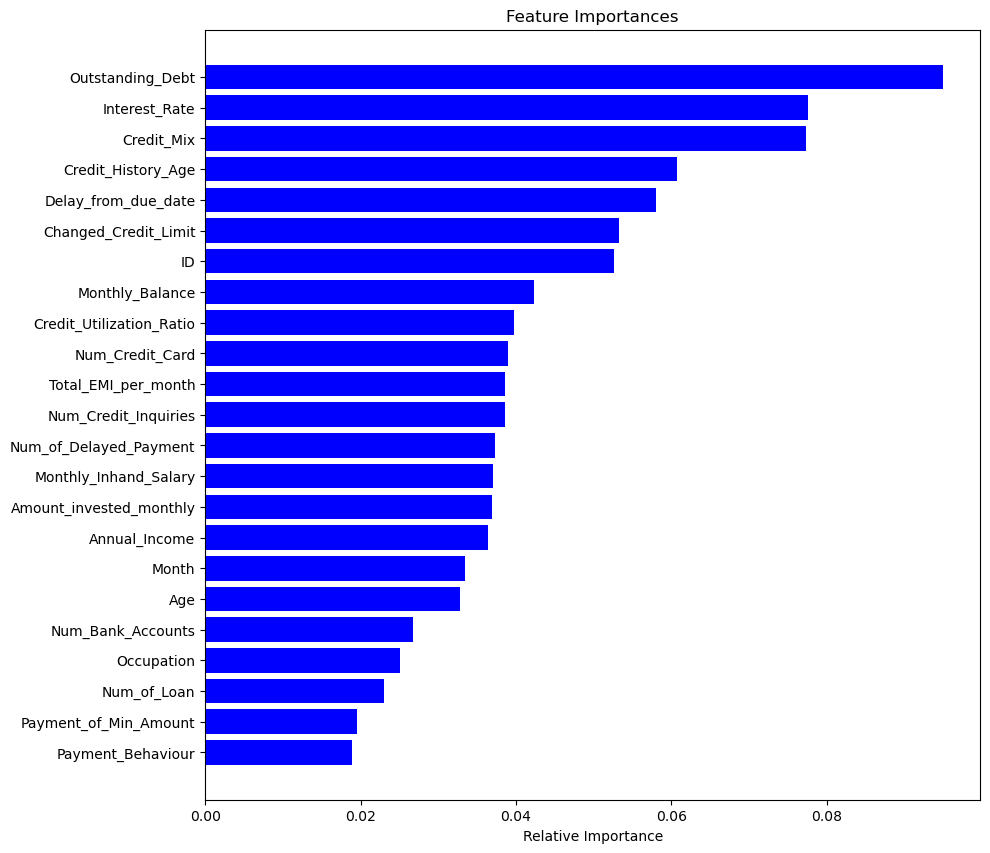

In [23]:
RF = RandomForestClassifier()
RF.fit(X_train, y_train)
importances = RF.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

We also plot a learning curve to observe if overfitting will be a problem. We see that the training score stays the same, at 100%, but the testing score increases as the length of the training set increases

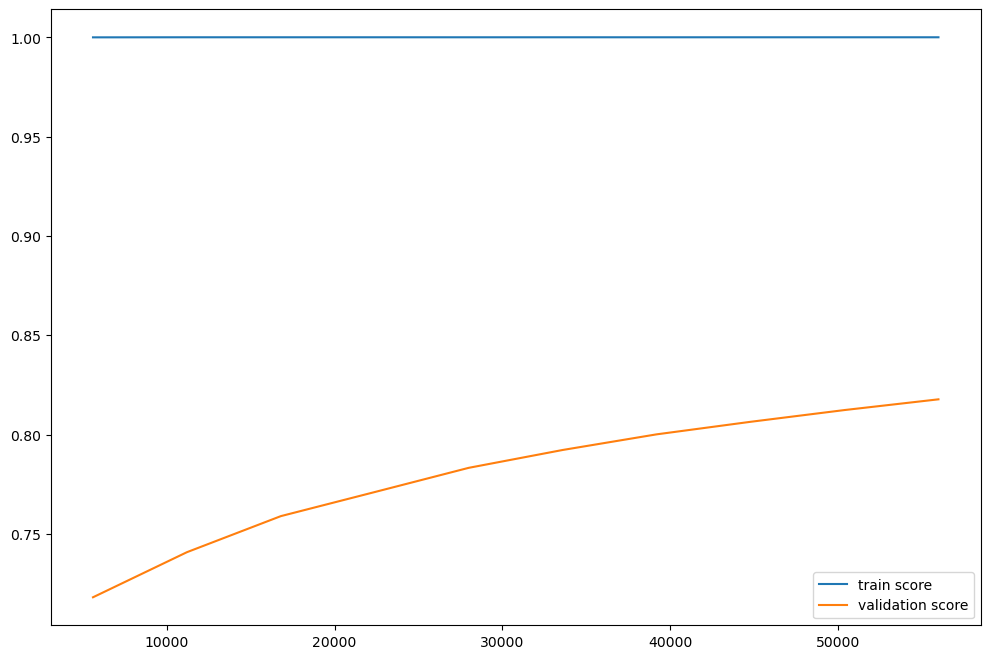

In [27]:
#LEARNING CURVE

RF= RandomForestClassifier(random_state= 0)
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)

def evaluation(model):

    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=kfold, scoring='accuracy',
                                               train_sizes=np.linspace(0.1, 1, 10))


    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()

evaluation(RF)

We also test the performance of this baseline model to have a benchmark before applying feature engineering. We use stratified cross validation to make sure our model isn't overfitting, will perform well on new, unseen data, and to keep the same proportion of classes. We reach an accuracy of 81.77%

In [24]:
model = RandomForestClassifier(random_state=0, n_jobs=  -1)
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)
scores = cross_val_score(model, X_train, y_train, cv=kfold)
print(f'These are the cross validation scores {scores.mean()}')

These are the cross validation scores 0.8177285714285715


We encode credit_mix using Ordinal Encoding, in the same order than the way we encoded credit_score

In [103]:
def credit_mix_encode(train, test):
    desired_categories_2 = ['Good', 'Standard', 'Bad']
    feature_encoder_2 = OrdinalEncoder(categories = [desired_categories_2])
    train[ 'Credit_Mix'] = feature_encoder_2.fit_transform(train[ 'Credit_Mix'].values.reshape(-1, 1))
    test[ 'Credit_Mix'] = feature_encoder_2.fit_transform(test[ 'Credit_Mix'].values.reshape(-1, 1))

    return train, test

We encode the occupation of our customers ranked on highest to lowest income (because our credit score is ranked as Good, Standard, then Poor).
Encoding as binary values led to lower accuracy on the model.

In [104]:
def ordinal_encode_occupation(train, test):
    #Occupation ranked from highest to lowest annual income on all data
    desired_categories_3 = ['Musician', 'Writer', 'Manager', 'Architect' , 'Scientist', 'Entrepreneur', 'Media_Manager', 'Accountant',\
                             'Engineer', 'Developer', 'Mechanic', 'Teacher', 'Doctor' ,'Lawyer', 'Journalist']
    feature_encoder_3 = OrdinalEncoder(categories = [desired_categories_3])
    train['Occupation'] = feature_encoder_3.fit_transform(train['Occupation'].values.reshape(-1, 1))
    test['Occupation'] = feature_encoder_3.fit_transform(test['Occupation'].values.reshape(-1, 1))

    return train, test

Label encoder is also used for Payment_Behaviour and for Payment_of_Min_Amount as it led to better accuracy than binary encoding

In [105]:
def label_encode_payment_behaviour(train, test, label_encoder):
    train['Payment_Behaviour'] = label_encoder.fit_transform(train['Payment_Behaviour'])
    test[ 'Payment_Behaviour'] = label_encoder.fit_transform(test[ 'Payment_Behaviour'])

    return train, test

def label_encode_payment_of_min_amt(train, test, label_encoder):
    train['Payment_of_Min_Amount'] = label_encoder.fit_transform(train['Payment_of_Min_Amount'])
    test[ 'Payment_of_Min_Amount'] = label_encoder.fit_transform(test[ 'Payment_of_Min_Amount'])

    return train, test

The data is then normalized to have a common scale for all our variables (example : Annual Income and Age)

In [106]:
def normalize(X_train, X_test):
    scaler = preprocessing.StandardScaler()
    scaler.fit(X_train)

    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

    return X_train_scaled_df, X_test_scaled_df

Finally, we preprocess our data calling the methods we defined above; we also drop the features deemed as unimportant, in this case Name, SSN (social security number).
Finally, we also create new variables that capture interaction between the features that had the highest importance in our baseline Random Forest Model

In [107]:
def preprocess(train, test):

    #Drop unnecessary columns : Customer_id, Name, SSN,
    train_data_filter = train.drop(columns=["Name", 'SSN','Type_of_Loan'])
    test_data_filter = test.drop(columns=["Name", 'SSN', 'Type_of_Loan' ])

    #Adding feature interaction:
    train_data_filter['income_age'] = train_data_filter['Annual_Income']*train_data_filter['Age']
    test_data_filter['income_age'] = test_data_filter['Annual_Income']*test_data_filter['Age']

    test_data_filter['card_bank'] = test_data_filter['Num_Bank_Accounts']*test_data_filter['Num_Credit_Card']
    train_data_filter['card_bank'] = train_data_filter['Num_Bank_Accounts']*train_data_filter['Num_Credit_Card']

    train_data_filter['DTI_ratio'] = (train_data_filter['Outstanding_Debt']/train_data_filter['Annual_Income'])*100
    test_data_filter['DTI_ratio'] = (test_data_filter['Outstanding_Debt']/test_data_filter['Annual_Income'])*100

    train_data_filter['ITS_ratio'] = (train_data_filter['Amount_invested_monthly']/train_data_filter['Monthly_Inhand_Salary'])*100
    test_data_filter['ITS_ratio'] = (test_data_filter['Amount_invested_monthly']/test_data_filter['Monthly_Inhand_Salary'])*100

    train_data_filter['Instalments_to_Salary'] = ((train_data_filter['Total_EMI_per_month']*12)/train_data_filter['Annual_Income'])*100
    test_data_filter['Instalments_to_Salary'] = ((test_data_filter['Total_EMI_per_month']*12)/test_data_filter['Annual_Income'])*100

    train_data_filter['Debt_over_time'] = ((train_data_filter['Outstanding_Debt'])/train_data_filter['Credit_History_Age'])
    test_data_filter['Debt_over_time'] = ((test_data_filter['Outstanding_Debt'])/test_data_filter['Credit_History_Age'])

    train_data_filter['Interest_Debt'] = ((train_data_filter['Interest_Rate']/100)*train_data_filter['Outstanding_Debt'])
    test_data_filter['Interest_Debt'] = ((test_data_filter['Interest_Rate']/100)*test_data_filter['Outstanding_Debt'])

    train_data_filter['Interest_time'] = ((train_data_filter['Interest_Rate'])/train_data_filter['Credit_History_Age'])
    test_data_filter['Interest_time'] = ((test_data_filter['Interest_Rate'])/test_data_filter['Credit_History_Age'])

    #calling encoding methods defined above

    train_data_filter, test_data_filter = credit_mix_encode(train_data_filter, test_data_filter)

    train_data_filter, test_data_filter = ordinal_encode_occupation(train_data_filter, test_data_filter)

    label_encoder = LabelEncoder()

    train_data_filter, test_data_filter = label_encode_payment_behaviour(train_data_filter, test_data_filter, label_encoder)
    train_data_filter, test_data_filter = label_encode_payment_of_min_amt(train_data_filter, test_data_filter, label_encoder)

    #Define X_train, X_test
    X_train = train_data_filter.drop(columns = 'Credit_Score' )
    X_test = test_data_filter
    X_test = X_test[X_train.columns]

    X_train, X_test= normalize(X_train, X_test)

    return X_train, y_train, X_test, feature_encoder


In [108]:
X_train, y_train, X_test, feature_encoder = preprocess(train_df, test_df)

Now we test again our model and see the impact of feature engineering. Our model has improved from 81.77% to 82.50%

In [63]:
model = RandomForestClassifier(criterion = 'log_loss',random_state=0, n_jobs=  -1)
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)
scores = cross_val_score(model, X_train, y_train, cv=kfold)
print(f'These are the cross validation scores {scores.mean()}')

These are the cross validation scores 0.8250857142857143


We also want to look at certain dimensionality reduction techniques, such as Principal Component Analysis and Singular Value Decomposition to test if we could reduce the number of variables without significantly loosing the variability in our data

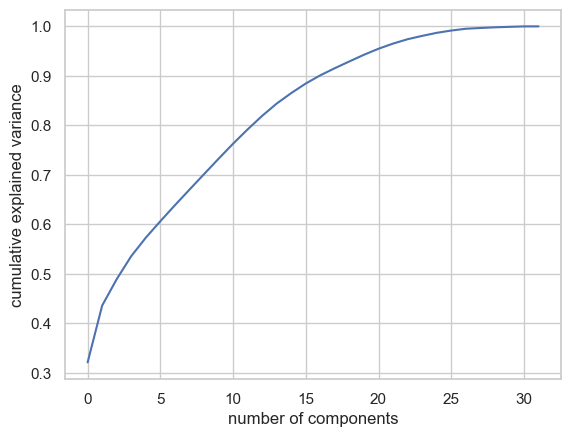

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.321323,0.321323
1,0.436107,0.114784
2,0.489424,0.053317
3,0.535961,0.046537
4,0.573188,0.037227
5,0.606441,0.033252
6,0.638722,0.032281
7,0.670155,0.031433
8,0.701444,0.031289
9,0.732524,0.031081


In [68]:
#PCA
import numpy as np
pca_test = PCA(n_components=32)
pca_test.fit(X_train)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
#plt.axvline(linewidth=4, color='r', linestyle = '--', x=10, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(32))

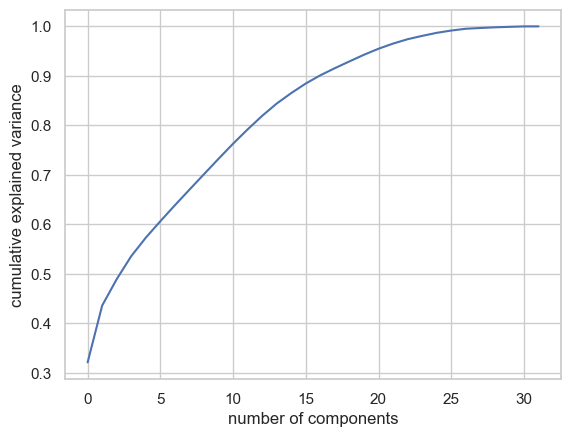

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.321323,0.321323
1,0.436107,0.114784
2,0.489424,0.053317
3,0.535961,0.046537
4,0.573188,0.037227
5,0.606441,0.033252
6,0.638722,0.032281
7,0.670155,0.031433
8,0.701444,0.031289
9,0.732524,0.031081


In [69]:
# Dimensionality reduction using SVD
# plot the explained variance ratio
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=32)
svd.fit(X_train)
sns.set(style='whitegrid')
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
#plt.axvline(linewidth=4, color='r', linestyle = '--', x=10, ymin=0, ymax=1)
display(plt.show())
evr = svd.explained_variance_ratio_
cvr = np.cumsum(svd.explained_variance_ratio_)
svd_df = pd.DataFrame()
svd_df['Cumulative Variance Ratio'] = cvr
svd_df['Explained Variance Ratio'] = evr
display(svd_df)

We see that we were not able to reduce our number of components without significantly reducing our model, therefore we decide not to use dimensionality reduction techniques here. 

# Parameter Tuning

We start with a randomized search CV, testing several values for 5 parameters, to narrow down our search of the best parameter tuning.

In [70]:
#Randomized search to add to optimize hyperparameter
kfold = StratifiedKFold(n_splits=2, random_state=42, shuffle = True)
model = RandomForestClassifier(random_state=0)

space = dict()
space['criterion'] = ['gini, log_loss', 'entropy']
space['n_estimators'] = [int(x) for x in np.linspace(start = 800, stop = 1300, num = 20)]
space['max_features'] = [4, 5, 6]
space['max_depth']= [20, 30, 60, 80]
space['min_samples_split'] : [2, 5, 7]

search = RandomizedSearchCV(model, space, scoring = 'accuracy', n_iter= 40,cv = kfold, refit = True)
result = search.fit(X_train, y_train)

# Obtain the best parameters
best_params = result.best_params_
print("Best Parameters:", best_params)



/Users/jojolapatate/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
32 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
32 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jojolapatate/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jojolapatate/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/jojolapatate/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 637, in _validate_params
    validate_parameter_

Best Parameters: {'n_estimators': 1010, 'max_features': 4, 'max_depth': 30, 'criterion': 'entropy'}


We create a dataframe ranking the best scores with the corresponding parameters, and then compare for each parameter value, the mean accuracy of their corresponding models. 

In [71]:
rs_df = pd.DataFrame(result.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_n_estimators,param_max_features,param_max_depth,param_criterion,mean_test_score,rank_test_score
0,1010,4,30,entropy,0.807586,1
1,1247,4,60,entropy,0.807371,2
2,1194,4,80,entropy,0.807371,2
3,957,5,80,entropy,0.807257,4
4,1221,5,80,entropy,0.807257,4
5,1273,5,60,entropy,0.807257,4
6,826,4,60,entropy,0.807243,7
7,1010,5,60,entropy,0.807171,8
8,826,5,80,entropy,0.807143,9
9,826,5,60,entropy,0.807143,9


/Users/jojolapatate/anaconda3/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/jojolapatate/anaconda3/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/jojolapatate/anaconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/jojolapatate/anaconda3/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/jojolapatate/anaconda3/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/jojolapatate/anaconda3/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs

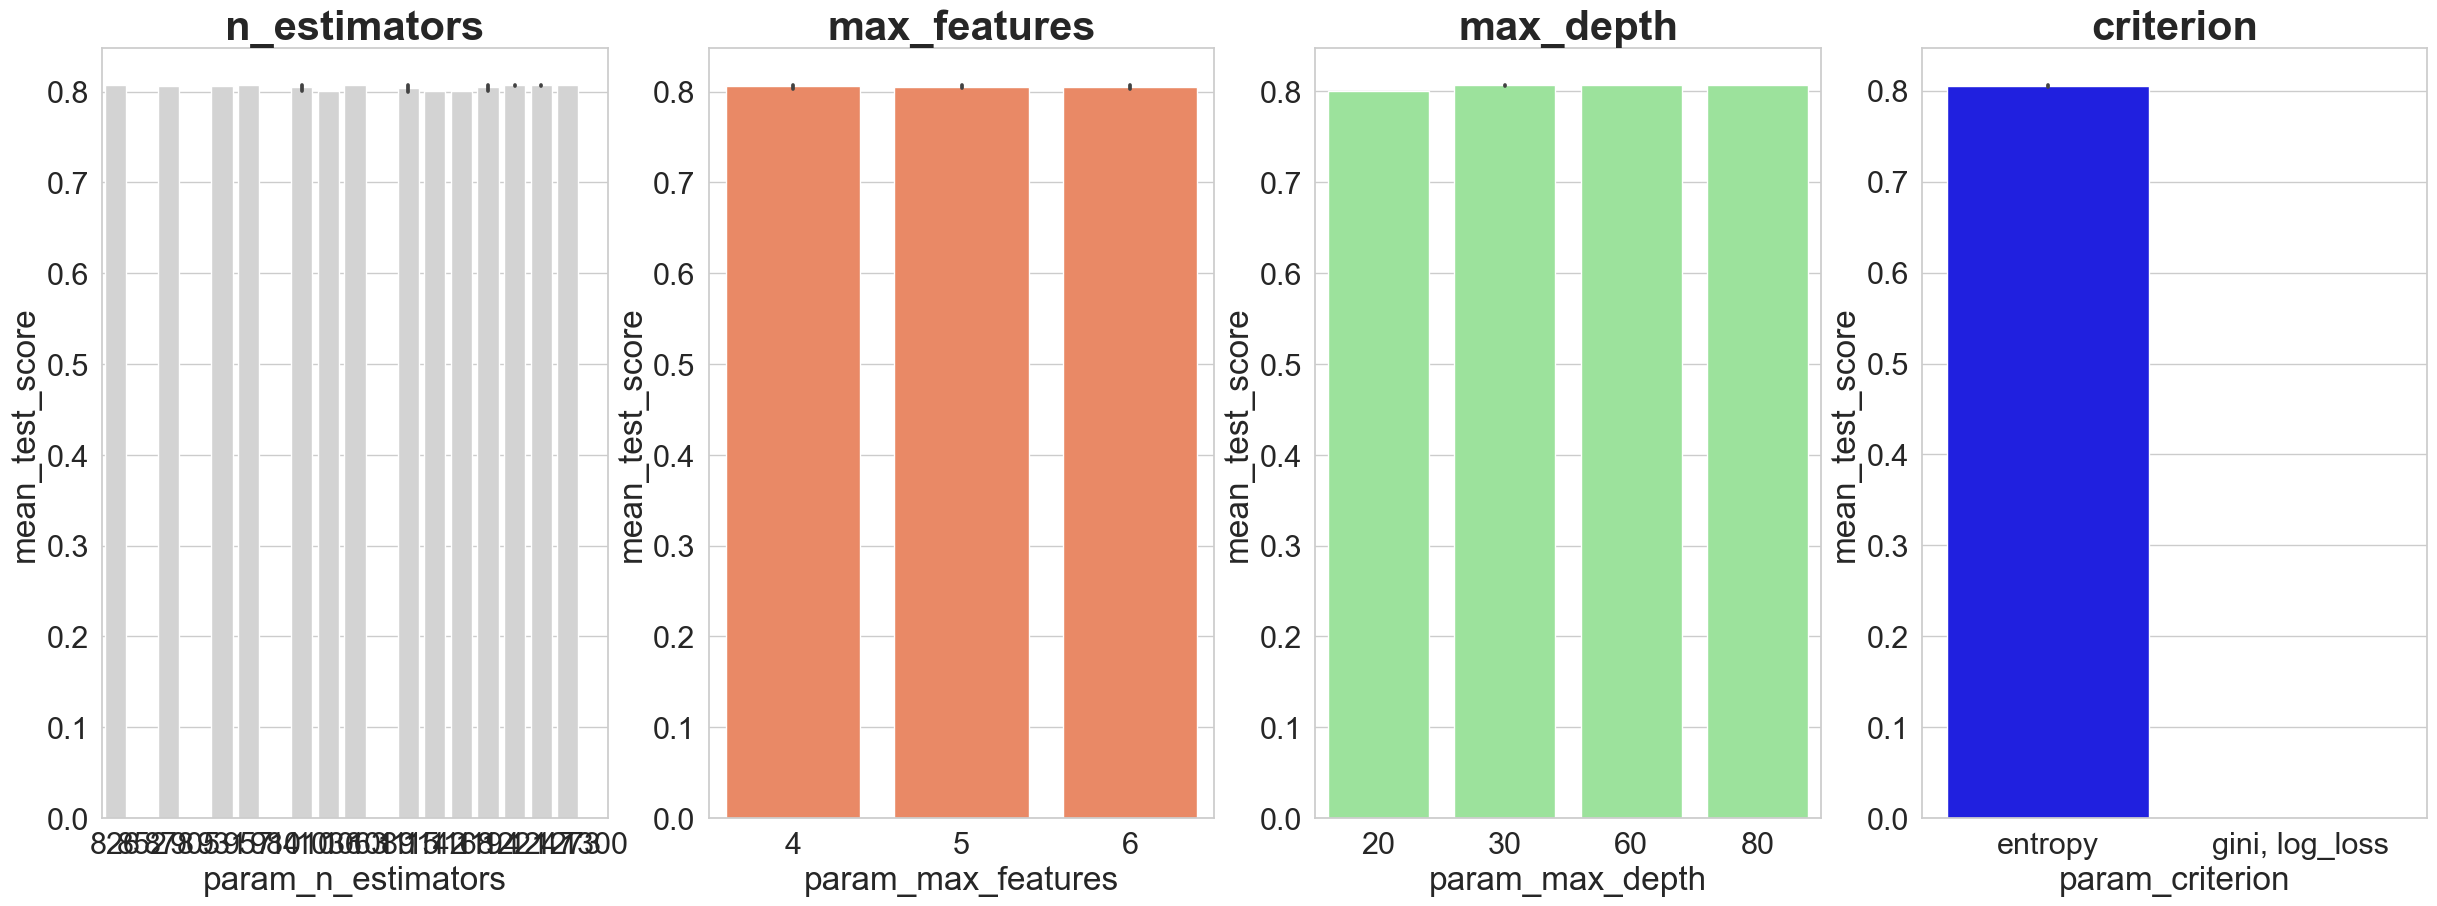

In [78]:
fig, axs = plt.subplots(ncols=4, nrows=1)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,10)

sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0], color='lightgrey')

axs[0].set_title(label = 'n_estimators', size=30, weight='bold')

sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1], color='coral')

axs[1].set_title(label = 'max_features', size=30, weight='bold')

sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[2], color='lightgreen')

axs[2].set_title(label = 'max_depth', size=30, weight='bold')




plt.show()

Plotting the accuracy by parameters, we see that parameter tuning has low impact on our model. Nevertheless, we are then able to make a  more targeted gridSearchCV, where we test every single combinations of parameters to obtain the best one.

In [96]:
kfold = StratifiedKFold(n_splits=2, random_state=42, shuffle = True)

space = dict()
space['criterion'] = ['log_loss', 'entropy']
space['n_estimators'] = [1100, 1200, 1300, 1500]
space['min_samples_split'] : [2, 4, 5]

# Obtain the best parameters
search = GridSearchCV(model, space, scoring = 'accuracy',cv = kfold, refit = True)
result = search.fit(X_train, y_train)

best_params = result.best_params_
print("Best Parameters:", best_params)


Best Parameters: {'criterion': 'log_loss', 'n_estimators': 1300, 'min_samples_split': 2}


Finally, we test our Random Forest model with the new, optimized parameter values and see the impact on our model's accuracy. 

In [112]:
model = RandomForestClassifier(random_state=0, criterion= 'log_loss', n_estimators= 1300, min_samples_split= 2, n_jobs=  -1)
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)
scores = cross_val_score(model, X_train, y_train, cv=kfold)
print(f'These are the cross validation scores :  {scores.mean()}')


These are the cross validation scores :  0.8353


We reach an accuracy of 83.53% on cross validation, and over 85% on the Kaggle competition (which is logical, since we are training a larger set our model becomes more accurate, as seen on the learning curve)